In [1]:
import pandas as pd
import numpy as np
import time
import requests
import json
from matplotlib import pyplot as plt
from influxdb_client_3 import InfluxDBClient3
from queryDSL import InfluxQueryBuilder, QueryFilter, QueryAggregation, Range, RelativeRange

In [2]:
INFLUXDB_TOKEN="VJK1PL0-qDkTIpSgrtZ0vq4AG02OjpmOSoOa-yC0oB1x3PvZCk78In9zOAGZ0FXBNVkwoJ_yQD6YSZLx23WElA=="
token = INFLUXDB_TOKEN
org = "Realtime Big Data"
host = "https://us-east-1-1.aws.cloud2.influxdata.com"
influx_client = InfluxDBClient3(host=host, token=token, org=org)
resetUrl = "http://127.0.0.1:5000/api/reset"
cacheUrlJson = "http://127.0.0.1:5000/api/query"

In [3]:
influxBuilder = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('300m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderMeasurements = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "memory_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('300m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderExtendedRange = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('600m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderGroupKeys = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "memory_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('600m', None)
               .withGroupKeys(["platform"])
       )

influxBuilderAggWindow = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("2m", "mean", False))
               .withRelativeRange('600m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderAggWindowGroupKeys = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("3m", "mean", False))
               .withRelativeRange('600m', None)
               .withGroupKeys(["platform"])
       )

influxBuilderAggWindowGroupKeysMeasurements = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature", "memory_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("10m", "mean", False))
               .withRelativeRange('600m', None)
               .withGroupKeys(["platform"])
       )

testQueries = [influxBuilder, influxBuilderMeasurements, influxBuilderExtendedRange, influxBuilderGroupKeys, influxBuilderAggWindow, influxBuilderAggWindowGroupKeys, influxBuilderAggWindowGroupKeysMeasurements]

In [34]:

from typing import List, Set, Dict
def runSuiteRaw(queryList: List[InfluxQueryBuilder], client: InfluxDBClient3):
    # Execute the query via client
    startTime = time.time()
    raw_times = []
    results = []
    for query in queryList:
        queryTime = time.time()
        queryStr = query.buildInfluxQlStr()
        table = client.query(query=queryStr, database="Test", language="influxql", mode='pandas')
        endTime = time.time() - queryTime
        raw_times.append(endTime)
        results.append(table)
    rawLatency = time.time() - startTime
    return rawLatency, raw_times

def runSuiteCache(queryList: List[InfluxQueryBuilder]):
    # Execute the query via cache service
    startTime = time.time()
    cached_times = []
    results = []
    queryTraces = []
    for query in queryList:
        queryJson = query.buildJson(doTrace=True)
        queryTime = time.time()
        cacheResp = requests.post(cacheUrlJson, json=queryJson)
        cacheJson = cacheResp.json()
        tableDf = pd.read_json(json.dumps(cacheJson.get("data")), orient='records')
        queryTrace = cacheJson.get("trace")
        endTime = time.time() - queryTime
        cached_times.append(endTime)
        results.append(tableDf)
        queryTraces.append(queryTrace)
    cacheLatency = time.time() - startTime
    return cacheLatency, cached_times, queryTraces

def isOutlier(runLatency, threshold):
    return runLatency > threshold

def collateTraces(traces: List[List[Dict[str, int]]]) -> List[Dict[str, float]]:
    sums = [{} for _ in range(len(traces[0]))]
    counts = [{} for _ in range(len(traces[0]))]

    for list_ in traces:
        for i, dict_ in enumerate(list_):
            for key, value in dict_.items():
                if key in sums[i]:
                    sums[i][key] += value
                    counts[i][key] += 1
                else:
                    sums[i][key] = value
                    counts[i][key] = 1

    means = [{} for _ in range(len(traces[0]))]
    for i in range(len(traces[0])):
        for key in sums[i]:
            means[i][key] = sums[i][key] / counts[i][key]

    return means

def runLatencyTest(queryList, iterations):
    rawLatencyList = []
    cacheLatencyList = []
    rawTimesList = []
    cachedTimesList = []
    queryTraceList = []
    for i in range(iterations):
        requests.post(resetUrl)
        cacheLatency, cached_times, queryTraces = runSuiteCache(queryList)
        rawLatency, raw_times = runSuiteRaw(queryList, influx_client)
        if not isOutlier(rawLatency, 1):
            rawLatencyList.append(rawLatency)
            rawTimesList.append(raw_times)
        if not isOutlier(cacheLatency, 1):
            cacheLatencyList.append(cacheLatency)
            cachedTimesList.append(cached_times)
            queryTraceList.append(queryTraces)
    requests.post(resetUrl)
    avg_raw_latency = np.mean(rawLatencyList)
    avg_cache_latency = np.mean(cacheLatencyList)
    avg_raw_times = np.mean(rawTimesList, axis=0)
    avg_cached_times = np.mean(cachedTimesList, axis=0)
    avg_query_traces = collateTraces(queryTraceList)
    return avg_raw_latency, avg_cache_latency, avg_raw_times, avg_cached_times, avg_query_traces

In [35]:
runSuiteCache(testQueries)
rawLatency, cacheLatency, raw_times, cached_times, avg_query_traces = runLatencyTest(testQueries, 50)
print("Raw Latency: ", rawLatency)
print("Cache Latency: ", cacheLatency)
print("Raw Times: ", raw_times)
print("Cached Times: ", cached_times)
print("Query Traces: ", avg_query_traces)

Raw Latency:  0.7048290822564102
Cache Latency:  0.44905163930810016
Raw Times:  [0.14000411 0.10141884 0.11208547 0.0861864  0.08257268 0.10396899
 0.07858152]
Cached Times:  [0.18898339 0.02021218 0.17501869 0.01776945 0.02128853 0.01359276
 0.01210318]
Query Traces:  [{'CheckCache': 8.862951527471127e-06, 'CombineAndSet': 0.0011665561924809995, 'InfluxQuery': 0.16638606009276016, 'ReconstructResult': 0.0018208959828252378}, {'CheckCache': 1.1615131212317426e-05, 'ReconstructResult': 0.0020482902941496477}, {'CheckCache': 9.837357894234035e-06, 'CombineAndSet': 0.0021251180897588315, 'InfluxQuery': 0.14179951729981796, 'ReconstructResult': 0.0011781039445296578}, {'CheckCache': 9.578207264775815e-06, 'ReconstructResult': 0.002619712249092434}, {'CheckCache': 9.059906005859375e-06, 'ReconstructResult': 0.007336212241131327}, {'CheckCache': 9.225762408712637e-06, 'ReconstructResult': 0.005351823309193487}, {'CheckCache': 8.58306884765625e-06, 'ReconstructResult': 0.005998891332875128}]

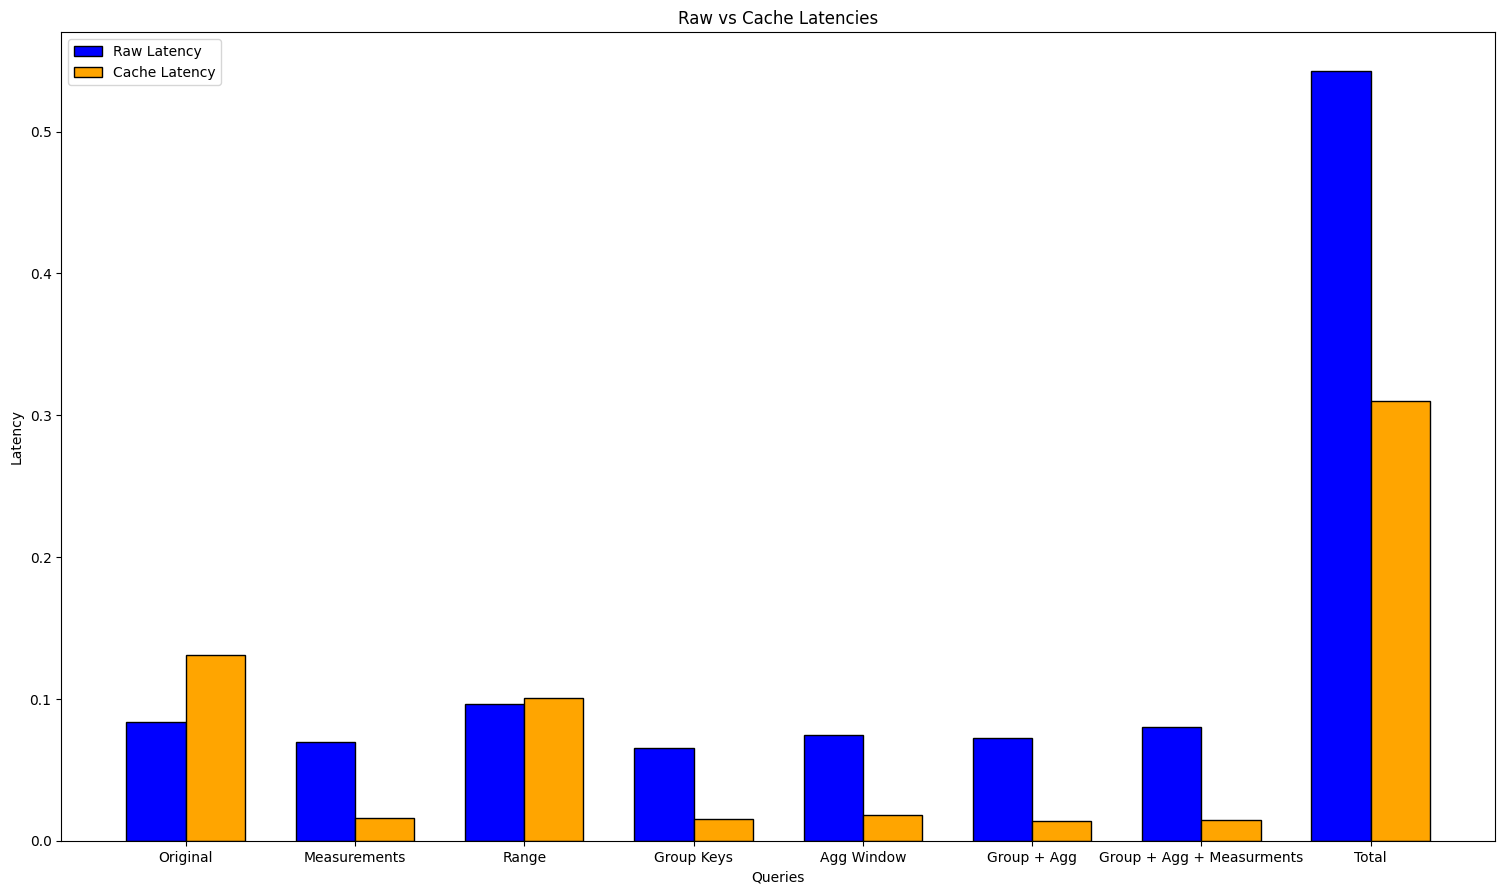

In [173]:
import matplotlib.pyplot as plt

labels = ['Original', 'Measurements', 'Range', 'Group Keys', 'Agg Window', 'Group + Agg', 'Group + Agg + Measurments', 'Total']
all_raw_times = np.append(raw_times, rawLatency)
all_cached_times = np.append(cached_times, cacheLatency)
# Set the width of the bars
bar_width = 0.35

r1 = range(len(all_raw_times))
r2 = [x + bar_width for x in r1]

plt.bar(r1, all_raw_times, color='blue', width=bar_width, edgecolor='black', label='Raw Latency')
plt.bar(r2, all_cached_times, color='orange', width=bar_width, edgecolor='black', label='Cache Latency')

plt.xlabel('Queries')
plt.ylabel('Latency')
plt.title('Raw vs Cache Latencies')
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)
#Increase figure width
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# Add a legend
plt.legend()

# Show the plot
plt.show()


In [36]:
import importlib
import queryDSL
importlib.reload(queryDSL)
from queryDSL import InfluxQueryBuilder, QueryFilter, QueryAggregation, Range, RelativeRange
from copy import copy


def runRangeLatencyComparison(baseQuery, ranges):
    rawLatencies = []
    cacheLatencies = []
    tracesList = []
    for newRange in ranges:
        baseQueryCopy = copy(baseQuery)
        modifiedBuilder = baseQueryCopy.withRelativeRange(newRange.fr, newRange.to)
        rawLatency, cacheLatency, rawLatenciesLs, cacheLatenciesLs, traces = runLatencyTest([baseQuery, modifiedBuilder], 30)
        rawLatencies.append(rawLatenciesLs[1])
        cacheLatencies.append(cacheLatenciesLs[1])
        tracesList.append(traces[1])
    return rawLatencies, cacheLatencies, tracesList

In [37]:
#reimport builtins
from builtins import range
startingRange = 720
baseInfluxBuilder = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "median", False))
               .withRelativeRange(f'{startingRange}m', None)
               .withGroupKeys(["host", "platform"])
       )

additionalRanges = []
for i in range(6):
    addition = 5 * (2 ** i)
    additionalRanges.append(RelativeRange(f'{startingRange + addition}m', None))
print(additionalRanges)

range_raws, range_cache, range_traces = runRangeLatencyComparison(baseInfluxBuilder, additionalRanges)
print("Raw Latencies: ", range_raws)
print("Cache Latencies: ", range_cache)
print("RangeTraces: ", range_traces)

[RelativeRange(fr: 725m, to: None), RelativeRange(fr: 730m, to: None), RelativeRange(fr: 740m, to: None), RelativeRange(fr: 760m, to: None), RelativeRange(fr: 800m, to: None), RelativeRange(fr: 880m, to: None)]
Raw Latencies:  [0.10275451890353499, 0.10628300905227661, 0.09626004695892335, 0.09048311463717756, 0.10481090729053204, 0.105081163603684]
Cache Latencies:  [0.11158338614872523, 0.09861421585083008, 0.09644437658375707, 0.09670102596282959, 0.1241927941640218, 0.12441792488098144]
RangeTraces:  [{'CheckCache': 1.2508460453578404e-05, 'CombineAndSet': 0.0020157950265066965, 'InfluxQuery': 0.07284403698784965, 'ReconstructResult': 0.0016094275883265904}, {'CheckCache': 1.0903676350911459e-05, 'CombineAndSet': 0.0017221848169962565, 'InfluxQuery': 0.0632423480351766, 'ReconstructResult': 0.0011232455571492514}, {'CheckCache': 1.049041748046875e-05, 'CombineAndSet': 0.0017584027915165342, 'InfluxQuery': 0.05906672313295562, 'ReconstructResult': 0.0013866506773850013}, {'CheckCach

In [38]:
def plot_comparison(raws, caches, labels):
    # Set the width of the bars
    bar_width = 0.35

    r1 = range(len(labels))
    r2 = [x + bar_width for x in r1]

    plt.bar(r1, raws, color='blue', width=bar_width, edgecolor='black', label='Raw Latency')
    plt.bar(r2, caches, color='orange', width=bar_width, edgecolor='black', label='Cache Latency')

    plt.xlabel('Queries')
    plt.ylabel('Latency')
    plt.title('Raw vs Cache Latencies with varying query ranges')
    plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)
    #Increase figure width
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

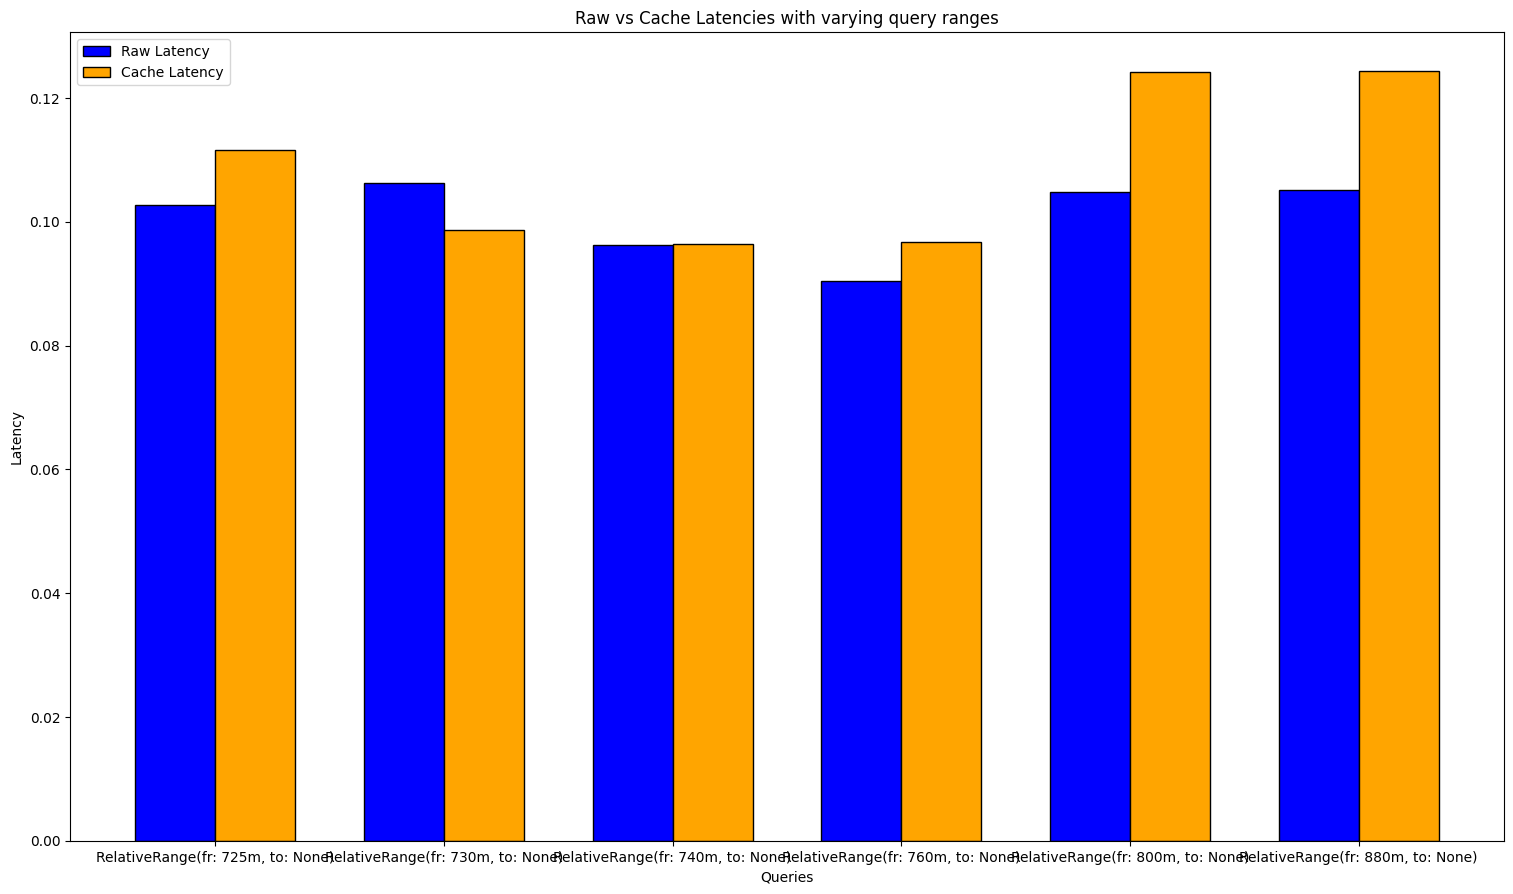

In [39]:
labels = [5, 10, 20, 40, 80, 160]
plot_comparison(range_raws, range_cache, labels)

In [168]:
#Compare efficiency of cache as query size increases
from builtins import range
starting_ranges = [60, 120, 240, 360, 720, 1440, 2880]

raw_latencies = []
cache_latencies = []
for starting_range in starting_ranges:
        baseInfluxBuilder = (InfluxQueryBuilder()
                .withBucket("Test")
                .withMeasurements(["cpu_usage", "temperature"])
                .withTable("system_metrics")
                .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
                .withAggregate(QueryAggregation("1m", "median", False))
                .withRelativeRange(f'{starting_range}m', None)
                .withGroupKeys(["host", "platform"])
        )
        additionalRanges = [RelativeRange(f'{starting_range + 10}m', None)]
        print(f"Starting Range: {starting_range}, Additional Range: {additionalRanges}")
        raw_latency, cache_latency = runRangeLatencyComparison(baseInfluxBuilder, additionalRanges)
        raw_latencies.append(raw_latency[0])
        cache_latencies.append(cache_latency[0])

print("Raw Latencies: ", raw_latencies)
print("Cache Latencies: ", cache_latencies)

Starting Range: 60, Additional Range: [RelativeRange(fr: 70m, to: None)]
Starting Range: 120, Additional Range: [RelativeRange(fr: 130m, to: None)]
Starting Range: 240, Additional Range: [RelativeRange(fr: 250m, to: None)]
Starting Range: 360, Additional Range: [RelativeRange(fr: 370m, to: None)]
Starting Range: 720, Additional Range: [RelativeRange(fr: 730m, to: None)]
Starting Range: 1440, Additional Range: [RelativeRange(fr: 1450m, to: None)]
Starting Range: 2880, Additional Range: [RelativeRange(fr: 2890m, to: None)]
Raw Latencies:  [0.09566729068756104, 0.09468727906545003, 0.07456084887186686, 0.10271847248077393, 0.13913741478553185, 0.18200998306274413, 0.2883141326904297]
Cache Latencies:  [0.14705610275268555, 0.1365298156080575, 0.09272270997365316, 0.10693842789222455, 0.10315828663962227, 0.13529299100240072, 0.2098030149936676]


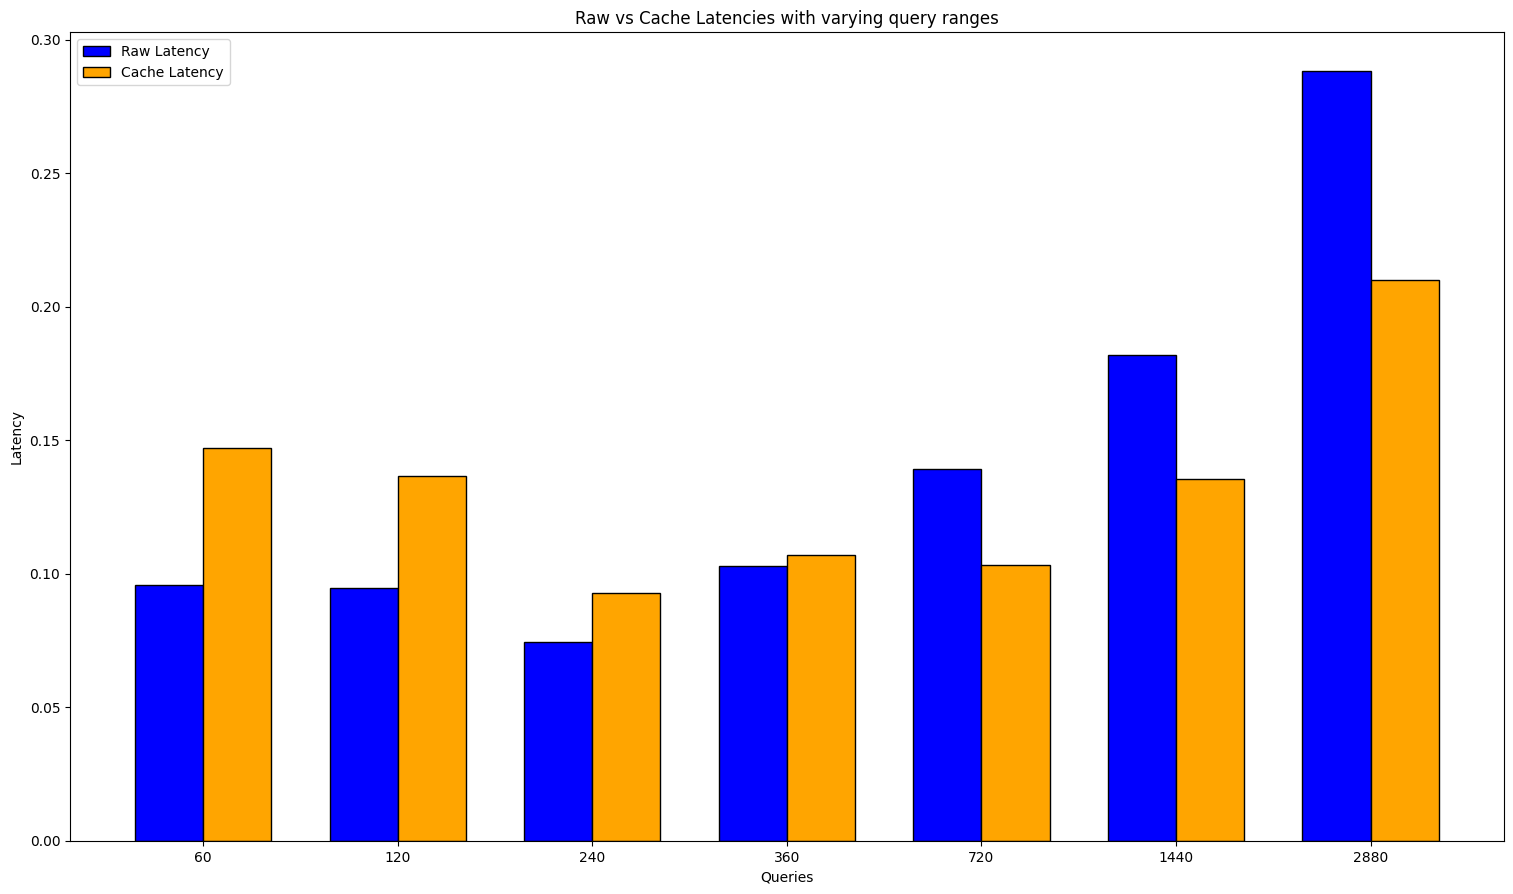

In [169]:
plot_comparison(raw_latencies, cache_latencies, starting_ranges)